# <font color=blue size="10">Analyze fit tuning curves of PV</font>

We use the function derived from a difference of gaussians (Mexican hat) receptive field to fit the bandwidth tuning curves.

The functional form for the TC with convention  r(b=0) = baseline:

$r(b) = R_{Bl} + R_D\, \mathrm{erf}\!\left(\frac{b}{\sqrt{2} \sigma_D}\right)^m - R_S\, \mathrm{erf}\!\left(\frac{b}{\sqrt{2} \sigma_S}\right)^m$

In [1]:
# set cell & response types, and global options for fit (including curve type: Carandini or difference of gaussian)
Celltype = 'PV'
CelltypeLabel = 'PV'
Response_type = 'sustained'

BLisZeroBW = True #whether to replace pure tone evoked rates with baseline (spontaneous) rates
WNoctave = 6 #what BW (in octaves) to attribute to white noise stimulus
mExp = 1 #parameter of curve (exponent). To allow m to be freely fit, set to None
curve_fit_class = "diff_of_gauss_fit" #enter "carandini_fit" or "diff_of_gauss_fit"

In [2]:
#import modules
nb_cell = 0
%run -i celltype_identified_TCfits_nb

importing modules



/Users/yashar/miniconda3/envs/myenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
#load experimental data
nb_cell = 1
%run -i celltype_identified_TCfits_nb

PVonsetResponses
PVsustainedResponses
SOMonsetResponses
SOMsustainedResponses
PVsustainedBaselineSpikeRates
ACsustainedResponses
stimulusBandwidth
AConsetBaselineSpikeRates
AConsetResponses
PVonsetBaselineSpikeRates
SOMsustainedBaselineSpikeRates
ACsustainedBaselineSpikeRates
SOMonsetBaselineSpikeRates


In [4]:
#fit TC's
nb_cell = 2
%run -i celltype_identified_TCfits_nb

  3%|▎         | 1/30 [00:00<00:03,  8.05it/s]/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_fit_funcs.py:221: RuntimeWarning: divide by zero encountered in double_scalars
  Stats['SuppInd'] = 1 - Stats['wnResp']/Stats['maxResp']
/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_fit_funcs.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  RawStats['SuppInd'] = 1 - RawStats['wnResp']/RawStats['maxResp']
100%|██████████| 30/30 [00:03<00:00,  9.00it/s]


 Elapsed time was 3.33356 seconds


### Goodness of fit

In [5]:
%matplotlib inline

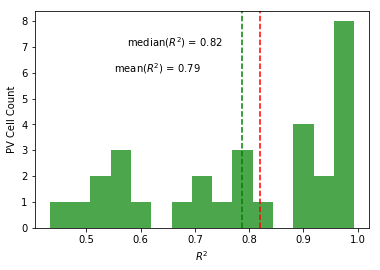

In [6]:
nb_cell = 3
%run -i celltype_identified_TCfits_nb
plt.show()

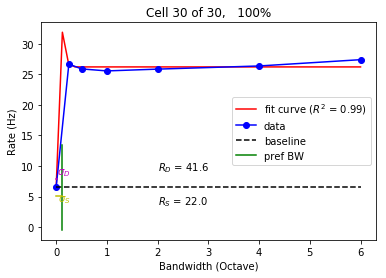

In [32]:
#visualize all fits, from worse to best
nb_cell = 4
pause = .05 #seconds of pause on each TC
%run -i celltype_identified_TCfits_nb

In [8]:
#Save all fit plots, from worse to best 
nb_cell = 5
# uncomment:
#%matplotlib inline
#%run -i celltype_identified_TCfits_nb

Check correlations

R2 , AbsPrefBW , Baseline , SuppInd_noBL , SuppInd_wBL , peakAbsResp , peakNegResp , peakRate , peakResp , peakSignedResp , prefBW , wnRate , wnResp


/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


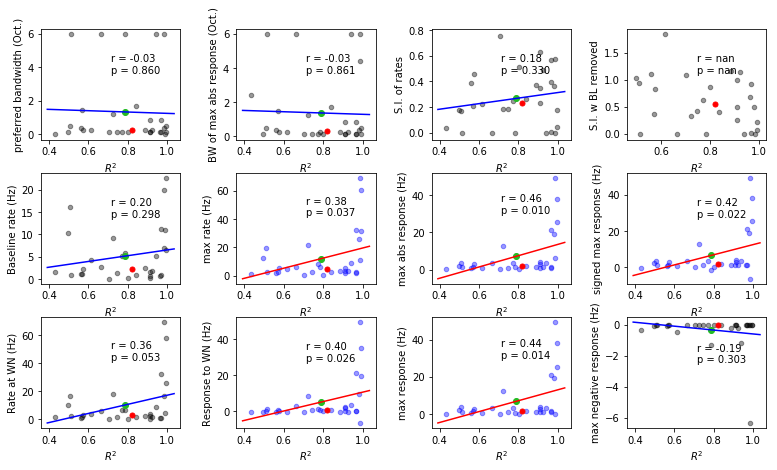

In [28]:
#check correlations of TC features with R^2 of fit
nb_cell = 6
%run -i celltype_identified_TCfits_nb
plt.show()

<style type="text/css">
body  {
   background-color:#E8E2E8;
};
</style>
<font color=#dd8010 size="4">
So there seems to be a weak relationship: cells with stronger response/rate have better fits

R2 , R0 , RD , RS , m , sigmaD , sigmaS


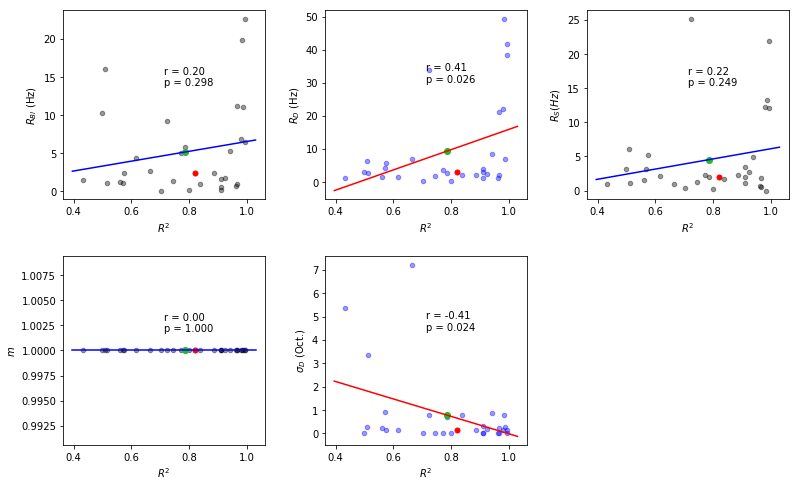

In [10]:
#check correlations of fit-parameters with R^2 of fit
nb_cell = 7
%run -i celltype_identified_TCfits_nb
plt.show()

## Tuning curve feature distributions

In [11]:
%matplotlib inline

AbsPrefBW , Baseline , SuppInd_noBL , SuppInd_wBL , peakAbsResp , peakNegResp , peakRate , peakResp , peakSignedResp , prefBW , wnRate , wnResp


/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Ncells = 30


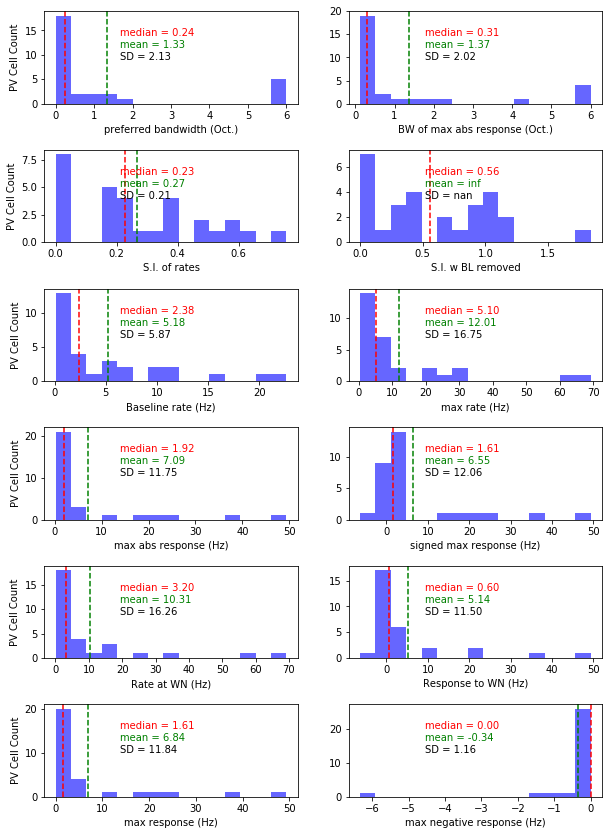

In [12]:
#plot TC features histogram
nb_cell = 8
%run -i celltype_identified_TCfits_nb
plt.show()

feature histograms from Raw TC's


/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


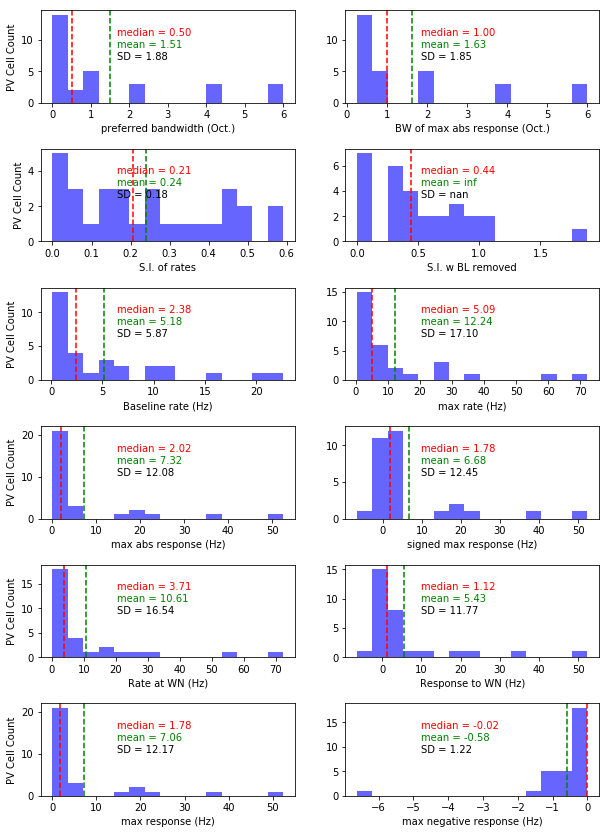

In [13]:
#plot TC features histogram, based on Raw TC's
nb_cell = 9
%run -i celltype_identified_TCfits_nb
plt.show()

/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]




 Comparing raw (y-axis) vs. fit-curve-extracted TC features


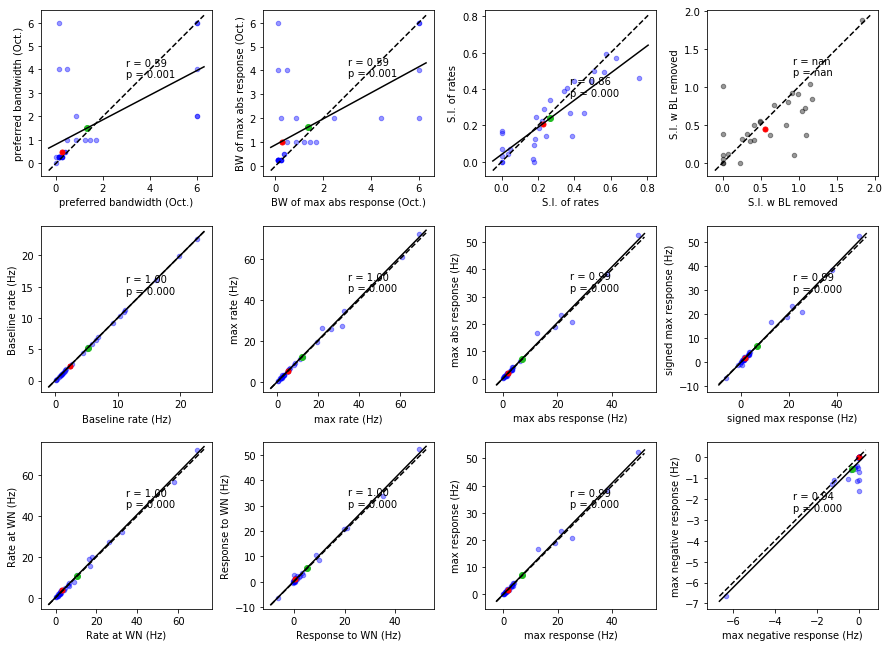

In [14]:
#plot TC features raw vs. fit
nb_cell = 10
%run -i celltype_identified_TCfits_nb
plt.show()

#### Correlations of preferred BW with other quantities:

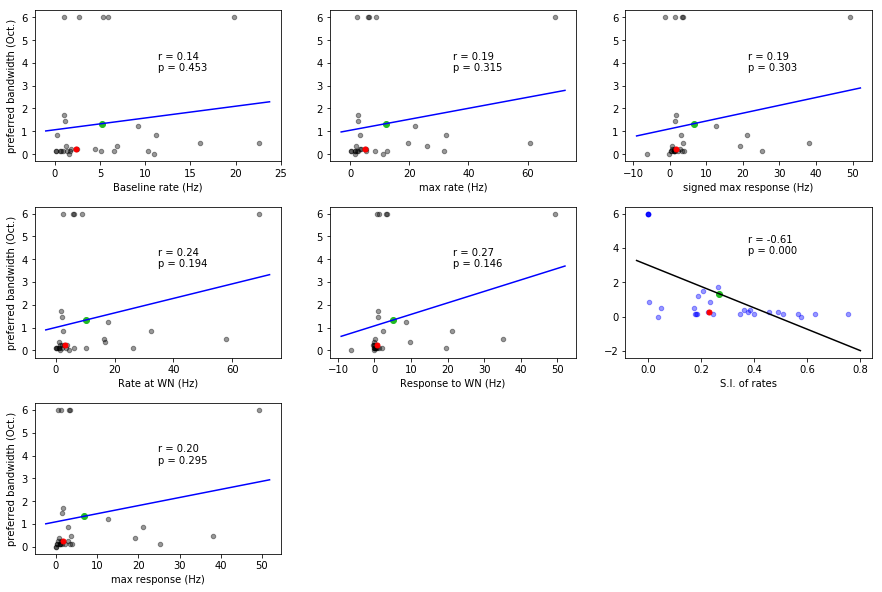

In [15]:
nb_cell = 11
%run -i celltype_identified_TCfits_nb
plt.show()

#### Correlations of *Suppression Index* with other quantities:

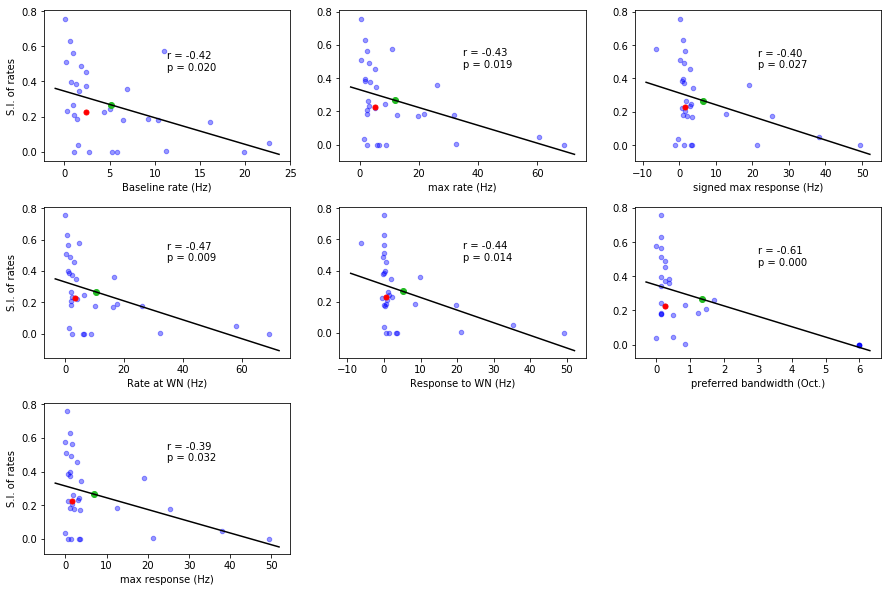

In [16]:
nb_cell = 12
%run -i celltype_identified_TCfits_nb
plt.show()

#### Correlations of rates and responses (not interesting)

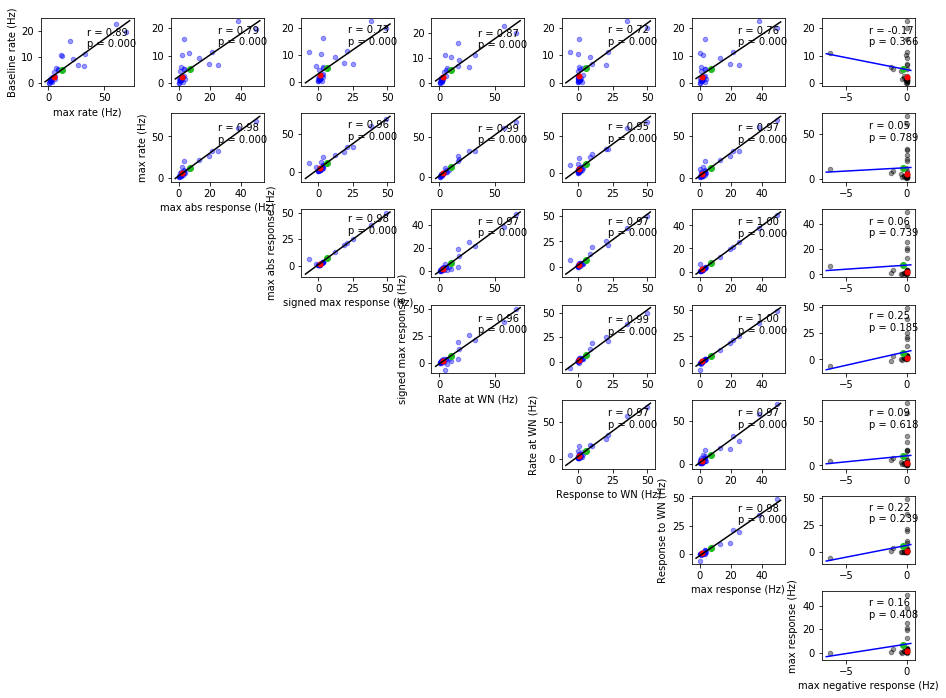

In [17]:
nb_cell = 13
%run -i celltype_identified_TCfits_nb
plt.show()

## Difference of Gaussians parameters

R0 , RD , RS , m , sigmaD , sigmaS
Ncells = 30


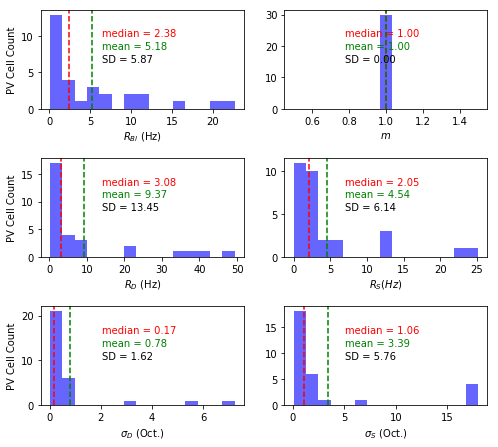

In [18]:
#plot histograms
nb_cell = 14
%run -i celltype_identified_TCfits_nb
plt.show()

Mean sigma_D is smaller for PV than E and SOM (in general), which may be consistent with 
another paper's (can't remember which) finding (told to me by Santiago) about the RF width of
the three cell types. 


On the other hand, mean sigma_S of PV and SOM is larger than E's, in line with their weaker surround suppression

/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


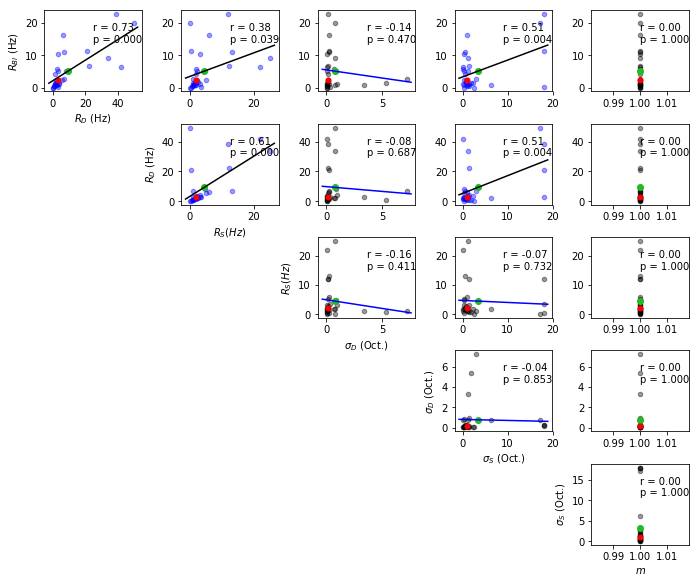

In [19]:
#cross-correlations:
nb_cell = 15
%run -i celltype_identified_TCfits_nb
plt.show()

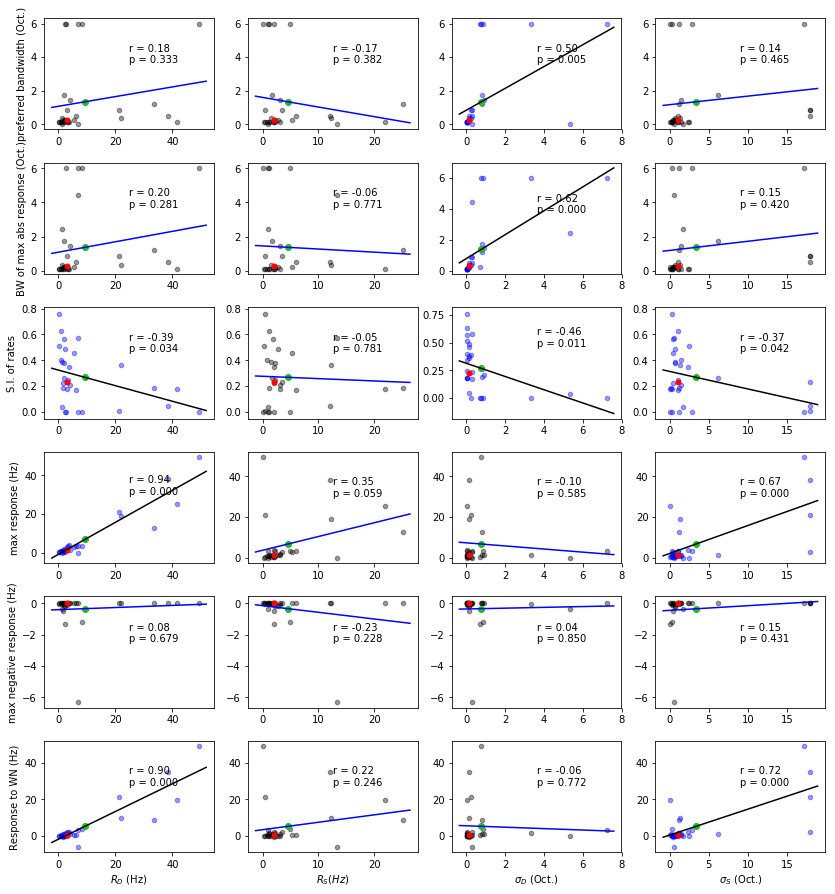

In [20]:
 #cross-correlations:
nb_cell = 16
%run -i celltype_identified_TCfits_nb
plt.show()

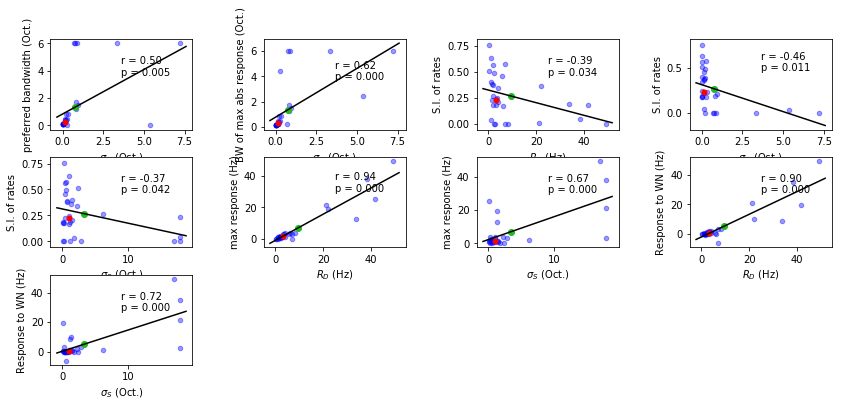

In [21]:
 #significant cross-correlations:
nb_cell = 17
%run -i celltype_identified_TCfits_nb
plt.show()

# Limiting to positively responsive cells



 29/30  of PV cells have a positive response.


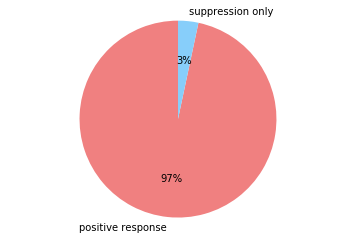

In [22]:
#pie chart
nb_cell = 18
%run -i celltype_identified_TCfits_nb
plt.show()

Ncells = 29


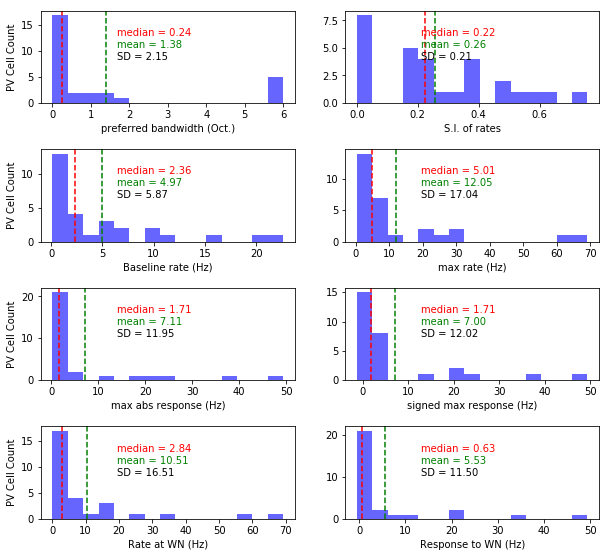

In [23]:
# features histograms after limiting to +response cells.
nb_cell = 19
%run -i celltype_identified_TCfits_nb
plt.show()

Ncells = 29


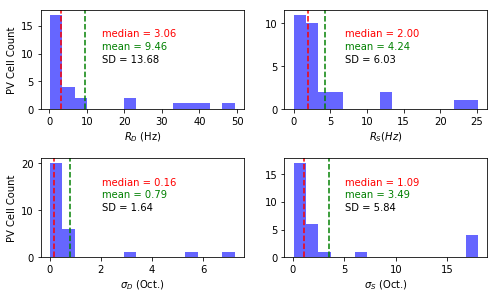

In [24]:
# curve parameters after limiting to +response cells.
nb_cell = 20
%run -i celltype_identified_TCfits_nb
plt.show()

<style type="text/css">
body  {
   background-color:#E8E2E8;
};
</style>
<font color=#dd8010 size="4">
Summary: It didn't really make a difference

# Limiting to SI>0 cells



 25/30  of PV cells have a suppression index > 0.


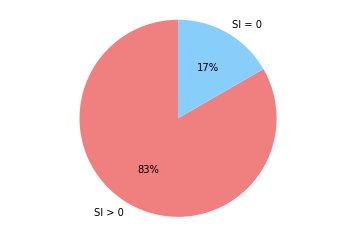

In [25]:
nb_cell = 21
%run -i celltype_identified_TCfits_nb
plt.show()

Ncells = 25


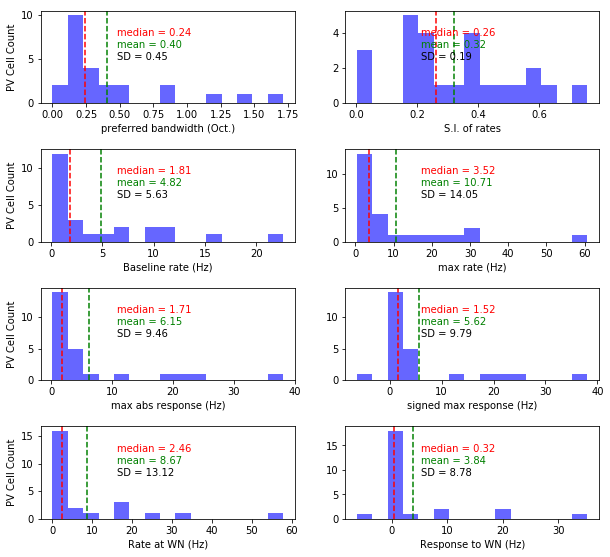

In [26]:
# features histograms after limiting to SI>0 cells.
nb_cell = 22
%run -i celltype_identified_TCfits_nb
plt.show()

Ncells = 25


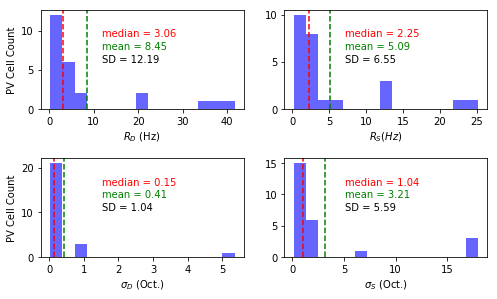

In [27]:
# curve parameters after limiting to SI>0 cells.
nb_cell = 23
%run -i celltype_identified_TCfits_nb
plt.show()